# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64',no_graphics=True)

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='Tennis_Linux/Tennis.x86_64',no_graphics=True)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
for brains in env.brain_names:
    print(brains)

TennisBrain


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_envs = len(env_info.agents)
print('Number of agents:', num_envs)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


In [4]:
len(states)

2

### 3. Loading DDPG Agent


In [5]:
from importlib import reload 
from collections import deque
import ddpg_agent, maddpg_agent
reload(ddpg_agent)
reload(maddpg_agent)
import torch
import torch.nn.functional as F
import torch.optim as optim
from ddpg_utils import OUNoise, Replay, transpose_to_tensor, Config
import model
reload(model)


<module 'model' from '/home/pinakigupta/Documents/Courses/deep-reinforcement-learning/DDPG-TennisEnv /model.py'>

In [6]:
import matplotlib.pyplot as plt

def plot_scores(scores,avg_scores = None):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    y_label = 'Score'
    plt.plot(np.arange(len(scores)), scores)
    if avg_scores is not None:
        y_label+=', Avg Score'
        plt.plot(np.arange(len(scores)), avg_scores)
    plt.ylabel(y_label)
    plt.xlabel('Episode #')
    plt.show()

In [7]:
config = Config(seed=6)

config.num_agents = len(env_info.agents)
config.state_size = state_size
config.action_size = action_size

config.actor_fn = lambda: model.Actor(config.state_size, config.action_size, 128, 128)
config.actor_opt_fn = lambda params: optim.Adam(params, lr=1e-3)

config.critic_fn = lambda: model.Critic(config.state_size, config.action_size , config.num_agents, 128, 128)
config.critic_opt_fn = lambda params: optim.Adam(params, lr=2e-3)

config.replay_fn = lambda: Replay(config.action_size, buffer_size=int(1e6), batch_size=128)
config.noise_fn = lambda: OUNoise(config.action_size, mu=0., theta=0.15, sigma=0.1 , seed=config.seed )

config.discount = 0.99
config.target_mix = 3e-3

config.max_episodes = 1500
config.max_steps = int(1e6)
config.goal_score = 2
config.checkpoint_score = 1

config.CHECKPOINT_FOLDER = "MultiAgentCheckPt"

In [8]:
def train(env = None, agent = None, config = None):
    
    
    scores_deque = deque(maxlen=100)
    mean_agent_scores = []
    goal_steps = []
    mean_mean_agent_scores = []
    checkpt_thresh = config.checkpoint_score
    for i_episode in range(1, config.max_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations            # get the current state
        #agent.reset()
        score = np.zeros(num_envs)
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations      # get the next states
            rewards = env_info.rewards                      # get the reward
            dones = env_info.local_done                     # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break

        #score = score.max()
        mean_agent_score = np.mean(score)
        mean_agent_scores.append(mean_agent_score)
        scores_deque.append(mean_agent_score)
        mean_mean_agent_score = np.mean(scores_deque)
        mean_mean_agent_scores.append(mean_mean_agent_score)

        print('\rEpisode {}\tAverage Score: {:.2f}\tscore: {:.2f}'.
              format(i_episode, np.mean(scores_deque), scores_deque[-1]), end="")
        
        if  mean_mean_agent_score >= checkpt_thresh:
            checkpt = "Episode=" + str(i_episode) + "Score=" + str(mean_mean_agent_score) + config.agentname
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            agent.checkpoint(checkpt)
            checkpt_thresh *= 1.5

        if  mean_mean_agent_score >=config.goal_score:
            checkpt = "Episode" + str(i_episode) + "Score=" + str(mean_mean_agent_score) + config.agentname
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            agent.checkpoint(checkpt)
            break   
    
    return mean_agent_scores, mean_mean_agent_scores

In [9]:
# MADDPG Agent (has a global critic )
config.agentname = "MADDPG"
maddpg_agent = maddpg_agent.Agent(config=config)

In [10]:
maddpg_scores , maddpg_avg_scores  = train( env = env,
                                            agent = maddpg_agent,
                                            config = config) 

/home/pinakigupta/anaconda3/envs/UdacityRL/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 977	Average Score: 1.01	score: 1.1500
Environment solved in 977 episodes!	Average Score: 1.01
Episode 1016	Average Score: 1.51	score: 2.55
Environment solved in 1016 episodes!	Average Score: 1.51
Episode 1500	Average Score: 0.95	score: 0.350

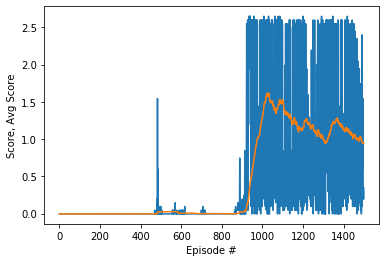

In [11]:
plot_scores(maddpg_scores, maddpg_avg_scores) # random replay scores

In [12]:
# DDPG Agent (has a local critic )
config.critic_fn = lambda: model.Critic(config.state_size, config.action_size , 1, 128, 128)
config.agentname = "DDPG"
ddpg_agent = ddpg_agent.Agent(config=config)

In [13]:
ddpg_scores , ddpg_avg_scores  = train( env = env,
                                        agent = ddpg_agent,
                                        config = config) 

Episode 1302	Average Score: 1.02	score: 2.600
Environment solved in 1302 episodes!	Average Score: 1.02
Episode 1340	Average Score: 1.52	score: 2.650
Environment solved in 1340 episodes!	Average Score: 1.52
Episode 1500	Average Score: 1.47	score: 2.600

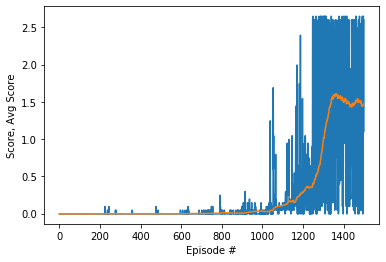

In [14]:
plot_scores(ddpg_scores, ddpg_avg_scores) # random replay scores

When finished, you can close the environment.

In [6]:
env.close()